In [66]:
#import librarys for data analysis
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_bar , coord_flip, geom_line
import matplotlib.pyplot as plt
from speedml import Speedml
from ydata_profiling import ProfileReport
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import minmax_scaling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import TargetEncoder
%matplotlib inline

In [3]:
#read in cleaned landslide data
clean_slide=pd.read_parquet("../1_data/CleanedLS.parquet")
clean_slide

,landslide_id,landslide_date,location_accuracy,category_landslide,landslide_trig,landslide_area,landslide_env,fatalities,injuries,risk
7209,10393,2017-09-28,exact,rock_fall,no_apparent_trigger,large,natural_slope,0,1,True
7210,10392,2017-09-27,exact,rock_fall,no_apparent_trigger,medium,natural_slope,1,1,True
3523,11013,2017-09-26,5km,mudslide,downpour,medium,natural_slope,0,0,False
3945,10971,2017-09-11,25km,landslide,flooding,unknown,unknown,2,0,True
5174,10991,2017-09-10,25km,landslide,rain,medium,natural_slope,0,9,True
...,...,...,...,...,...,...,...,...,...,...
9540,7831,1996-12-26,50km,debris_flow,freeze_thaw,small,above_river,0,0,False
9484,7830,1996-12-26,50km,debris_flow,freeze_thaw,small,above_road,0,0,False
9838,7408,1995-08-14,10km,debris_flow,downpour,large,unknown,0,0,False
10768,7331,1993-06-04,1km,other,rain,medium,deforested_slope,0,0,False


In [4]:
#create quick data analysis summary
Landslide_basics=ProfileReport(clean_slide,title="Landslide Quick Analysis",dark_mode=True)
clean_slide.describe()

,landslide_id,landslide_date,fatalities,injuries
count,10944.000000,10944,10944.000000,10944.000000
mean,5559.200475,2013-02-28 18:02:14.210526464,2.825567,0.363487
min,1.000000,1988-11-07 00:00:00,0.000000,0.000000
25%,2762.750000,2010-11-04 00:00:00,0.000000,0.000000
50%,5518.500000,2013-07-06 00:00:00,0.000000,0.000000
75%,8367.250000,2015-09-27 00:00:00,0.000000,0.000000
max,11221.000000,2017-09-28 00:00:00,5000.000000,374.000000
std,3231.955714,NaN,56.237670,5.929033


In [5]:
#display advanced summary and export it to html file
#Landslide_basics
#Landslide_basics.to_file("Landslide_Summary.html")

# Summary Report
### Serving most pertinent, is the average fatality occurence being higher than that of an injury by almost 8 times
### Baseline summary depicts further support that no missing data is present, the variables/features are set up properly, and significant statistics are present.
### Data shows emergence of useful data collection around 2008 and sporadic changes with slight growth in the years ahead.
### Majority records under landslide type fell under "landslide" whereas other types weren't as comparable, except for mudslide wihch held a 1/5th count in that category
### Downpour, rain, and natural occurances that emit water from the sky in a way were the leading cause of most landslides
### It is more common for a landslide to appear either medium or small in area coverage
### In regards to the environment of landslides, most were unknown, but the noted ones were predominantly above road
### An outlier was noted in fatalties with a maximum value of 5000 being present, future analysis needed to determine plausibility
### Severity of landslides seem to be higher with fatalities being a more common occurence than injuries are to occur
### Overall most landslides were likely to present no harm, having a ~20% chance that a negative altercation could occur
### Observation can be drawn at two key factor of the risk variable presented through the heatmap as the landslide area and environment, both having a positive correlation

In [6]:
#determine the validity of the 5000 fatality landslide
fatality_max=clean_slide.loc[clean_slide["fatalities"].idxmax()]
fatality_max

landslide_id                         4924
landslide_date        2013-06-16 00:00:00
location_accuracy                     1km
category_landslide            debris_flow
landslide_trig                   downpour
landslide_area                 very_large
landslide_env                     unknown
fatalities                           5000
injuries                                0
risk                                 True
Name: 5526, dtype: object

## After checking sources based on the landslide_id and date it is confirmed as a devestating landslide that occured in North India, 2013, taking the lives of at least 5700, the count not being accurate above that number, but to be consistent with other data points the count will remain unaltered in this analysis

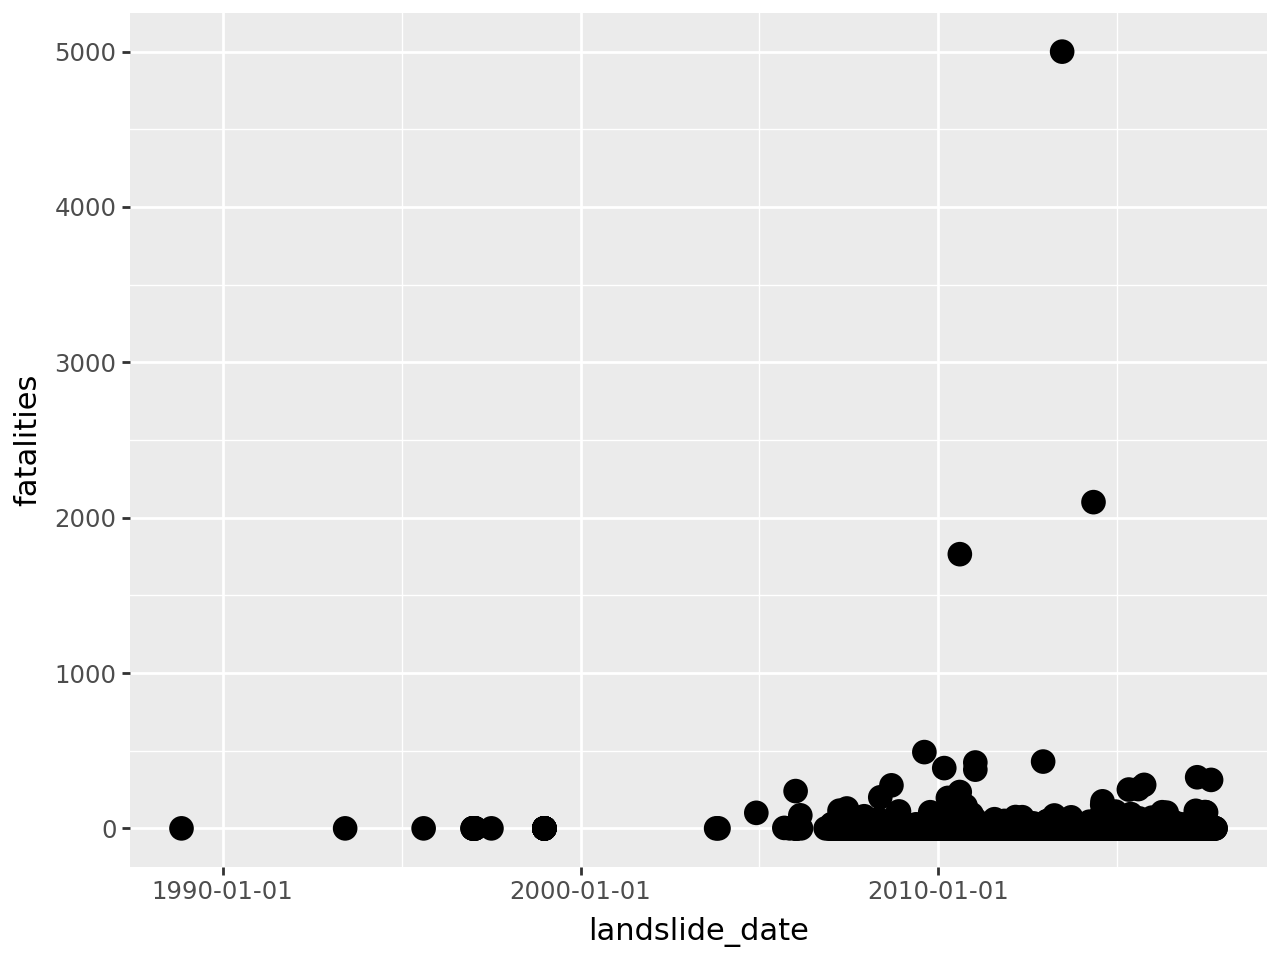

In [7]:
#draw a scatter plot to see spread of fatality occurence
ggplot(clean_slide)+aes(x="landslide_date", y="fatalities") + geom_point(size=4)

#only 3 discernable points can be discenered as an outlier 

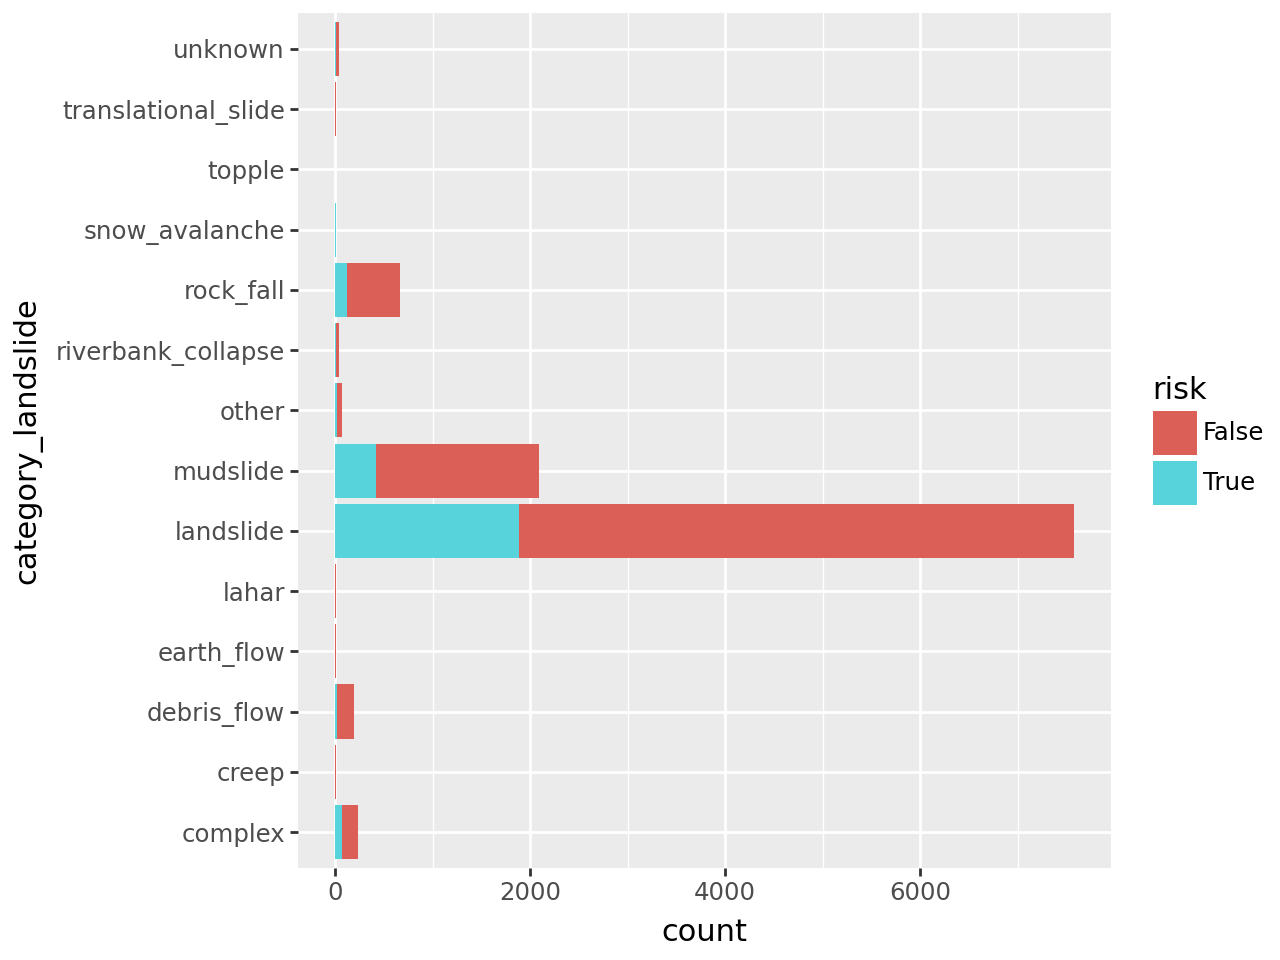

In [8]:
ggplot(clean_slide, aes(x='category_landslide', fill='risk')) + geom_bar() + coord_flip()

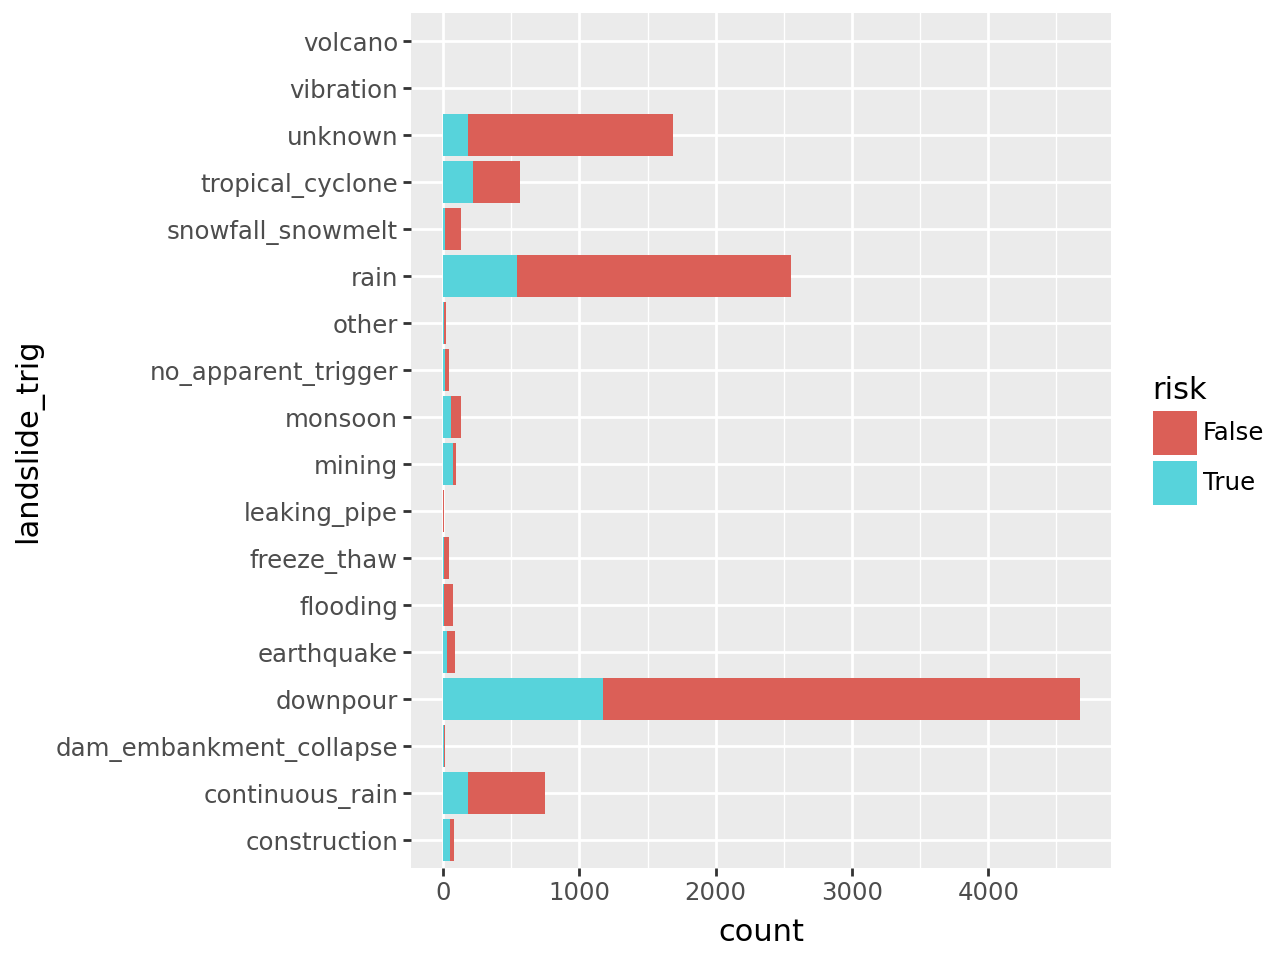

In [9]:
ggplot(clean_slide, aes(x='landslide_trig', fill='risk')) + geom_bar() + coord_flip()

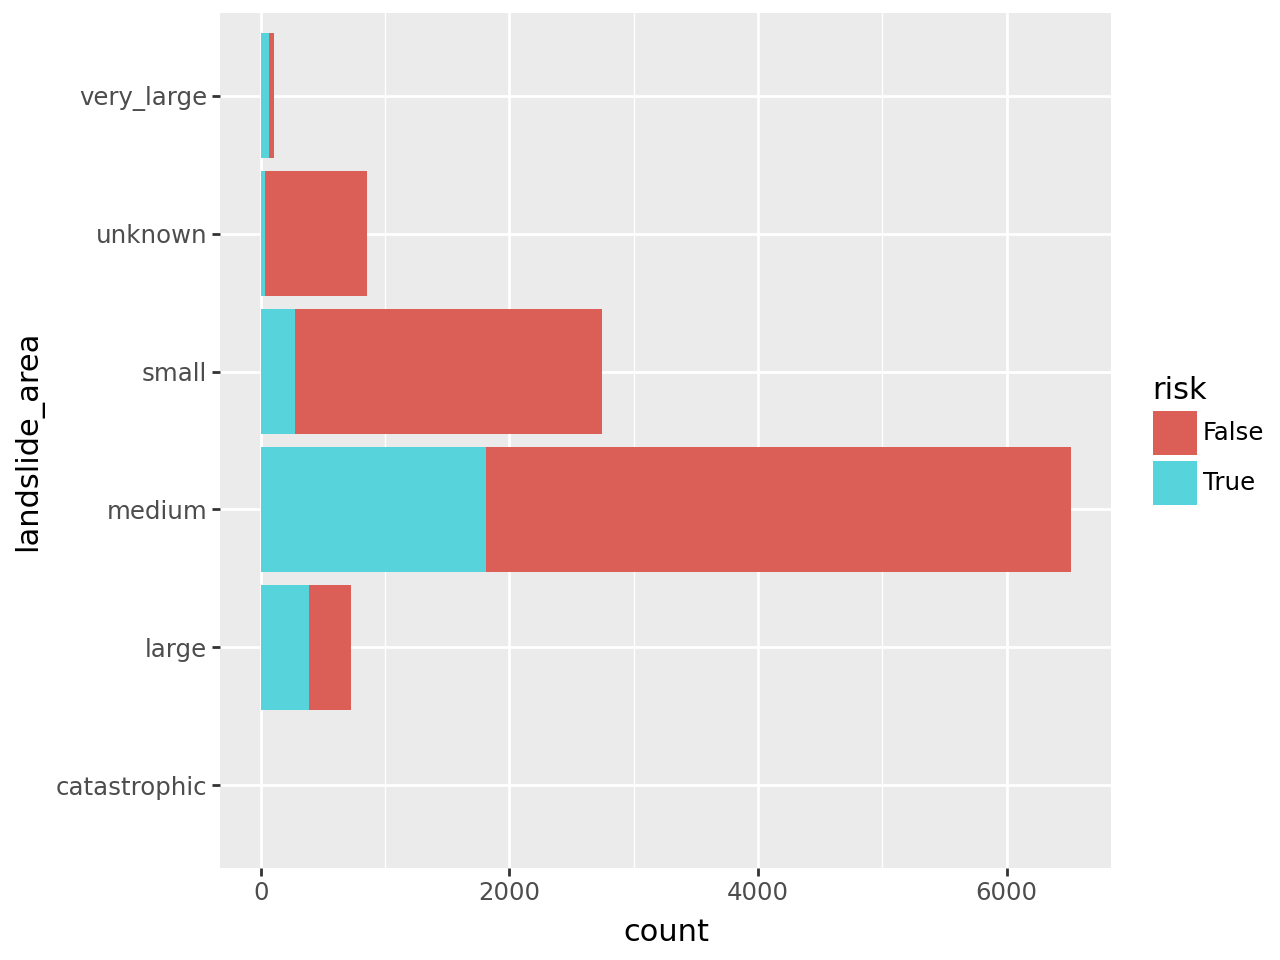

In [10]:
ggplot(clean_slide, aes(x='landslide_area', fill='risk')) + geom_bar() + coord_flip()

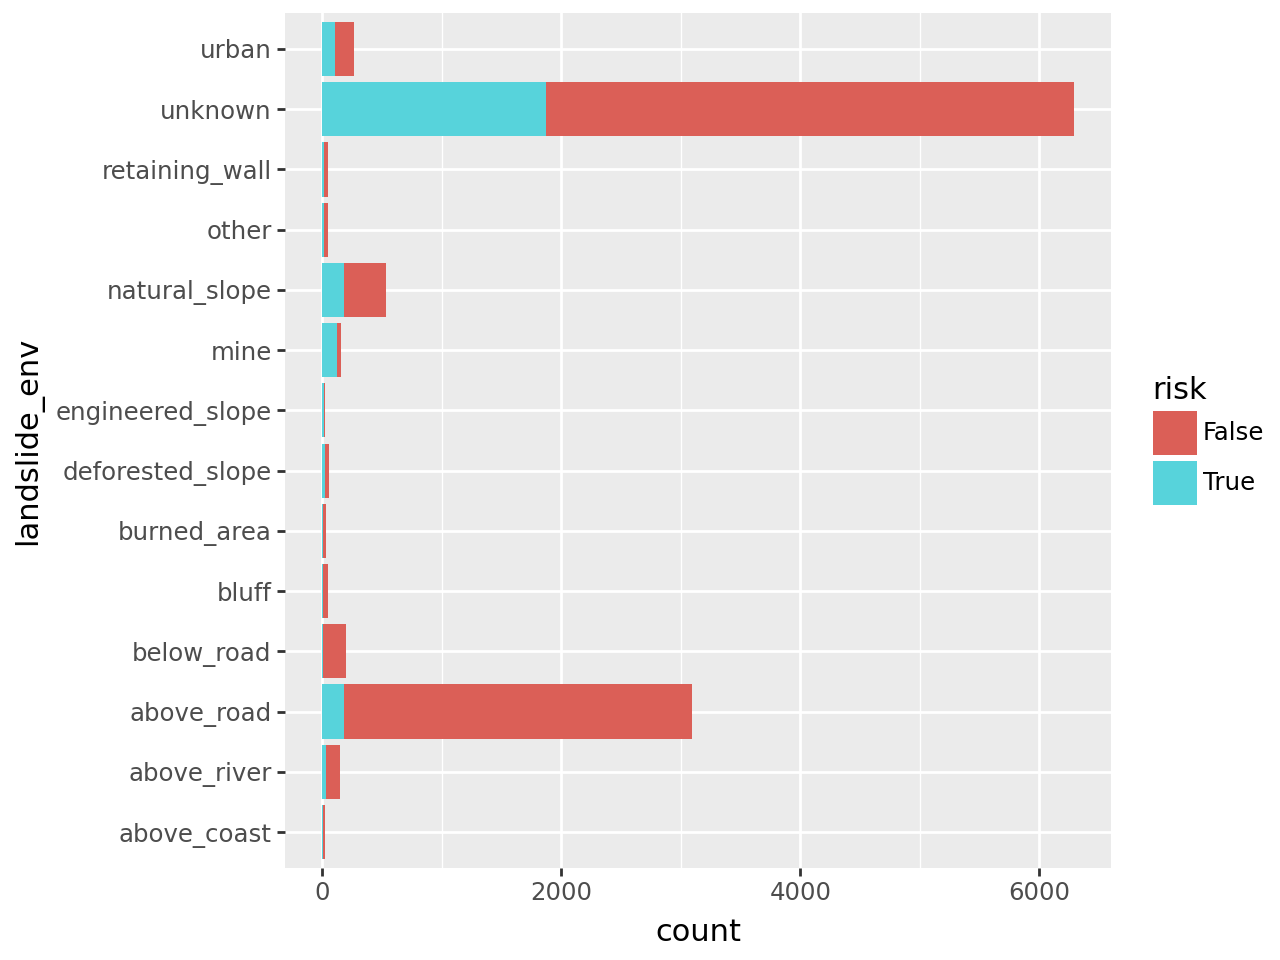

In [11]:
ggplot(clean_slide, aes(x='landslide_env', fill='risk')) + geom_bar() + coord_flip()

In [12]:
#create subset df to avoid the 3 abnormal landslides and limited data points before 2000
norm_fatalities=clean_slide[(clean_slide["fatalities"] < 1500) & (clean_slide["landslide_date"].dt.year>2000)]


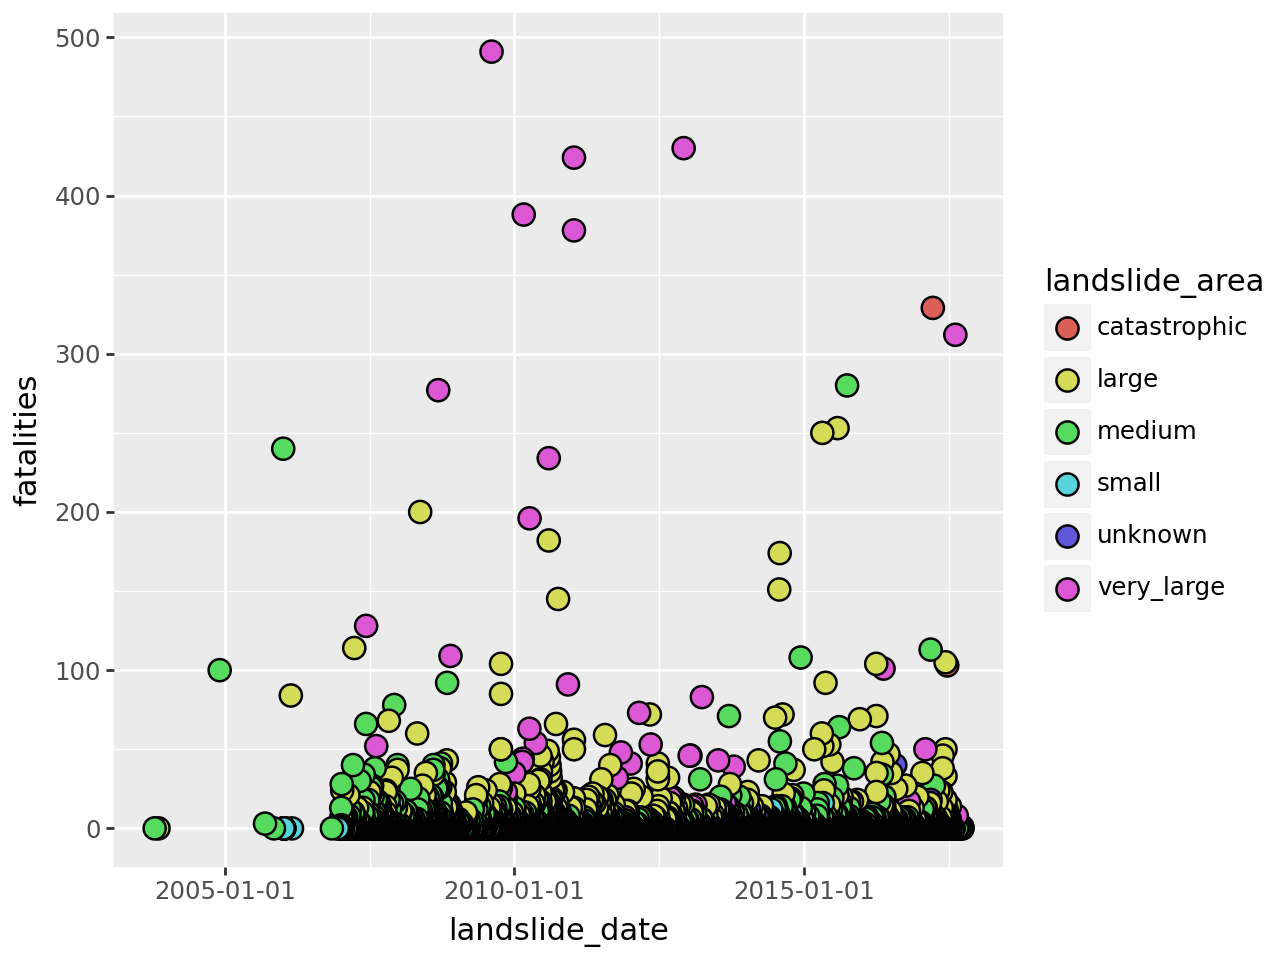

In [13]:
#check to see if outlier data was taken out
ggplot(norm_fatalities)+aes(x="landslide_date", y="fatalities",fill="landslide_area") + geom_point(size=4)

In [14]:
#find the fatality rate of only above road landslides
len(norm_fatalities[(norm_fatalities["landslide_env"] == "above_road") & (norm_fatalities["risk"] == True)]) / len(norm_fatalities[norm_fatalities["landslide_env"] == "above_road"]) *100 

5.8249267816465995

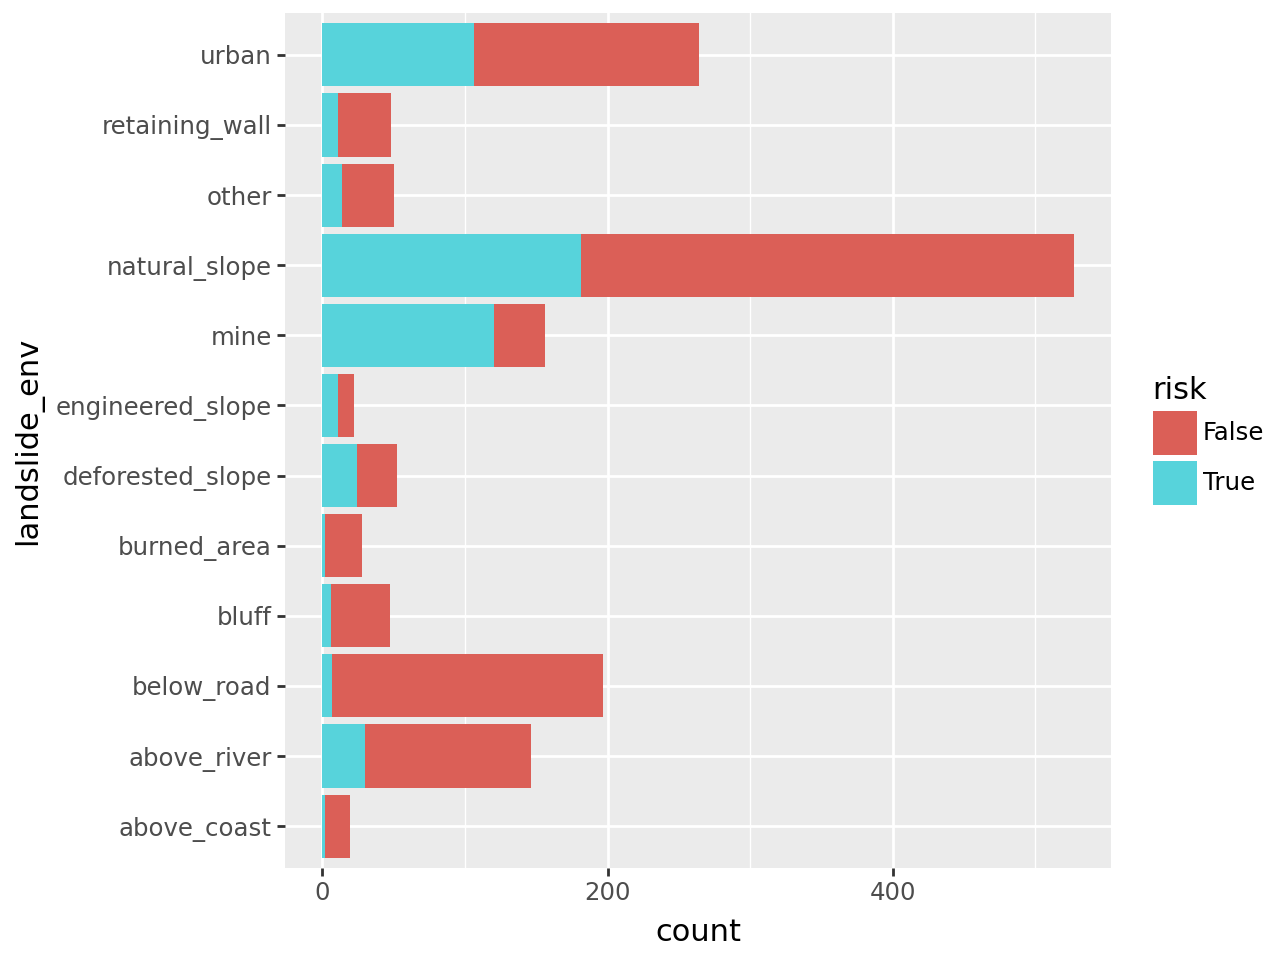

In [15]:
#with unknown providing a lack of value; consider collected landslide envs. and above road can be visualized as frequently occuring but only a 6% fatality occurence
ggplot(norm_fatalities[~norm_fatalities["landslide_env"].isin(["unknown", "above_road"])], aes(x='landslide_env', fill='risk')) + geom_bar() + coord_flip()

In [16]:
norm_fatalities

,landslide_id,landslide_date,location_accuracy,category_landslide,landslide_trig,landslide_area,landslide_env,fatalities,injuries,risk
7209,10393,2017-09-28,exact,rock_fall,no_apparent_trigger,large,natural_slope,0,1,True
7210,10392,2017-09-27,exact,rock_fall,no_apparent_trigger,medium,natural_slope,1,1,True
3523,11013,2017-09-26,5km,mudslide,downpour,medium,natural_slope,0,0,False
3945,10971,2017-09-11,25km,landslide,flooding,unknown,unknown,2,0,True
5174,10991,2017-09-10,25km,landslide,rain,medium,natural_slope,0,9,True
...,...,...,...,...,...,...,...,...,...,...
9996,7903,2005-11-06,5km,rock_fall,unknown,medium,above_road,0,0,False
10009,7904,2005-09-11,25km,rock_fall,unknown,medium,above_road,3,0,True
2843,6418,2004-11-29,1km,landslide,tropical_cyclone,medium,unknown,100,0,True
10361,7808,2003-11-09,1km,landslide,unknown,large,above_road,0,0,False


## Modeling

In [17]:
#create dupe df for modeling
norm_fatalities_dupe=norm_fatalities.copy()

In [18]:
#utilize a label encoder to convert categorical values to numerica
cat_list=["category_landslide","landslide_trig","landslide_area","landslide_env","location_accuracy"]
for x in cat_list:
    norm_fatalities_dupe[x]=LabelEncoder().fit_transform(norm_fatalities_dupe[x])

In [19]:
#drop columns that don't act as a feature/target
no_dt_df=norm_fatalities_dupe.drop(columns=["landslide_date","landslide_id"])

In [20]:
#scale date
scaled_slide=minmax_scaling(no_dt_df, columns = no_dt_df.columns.values)

<Axes: >

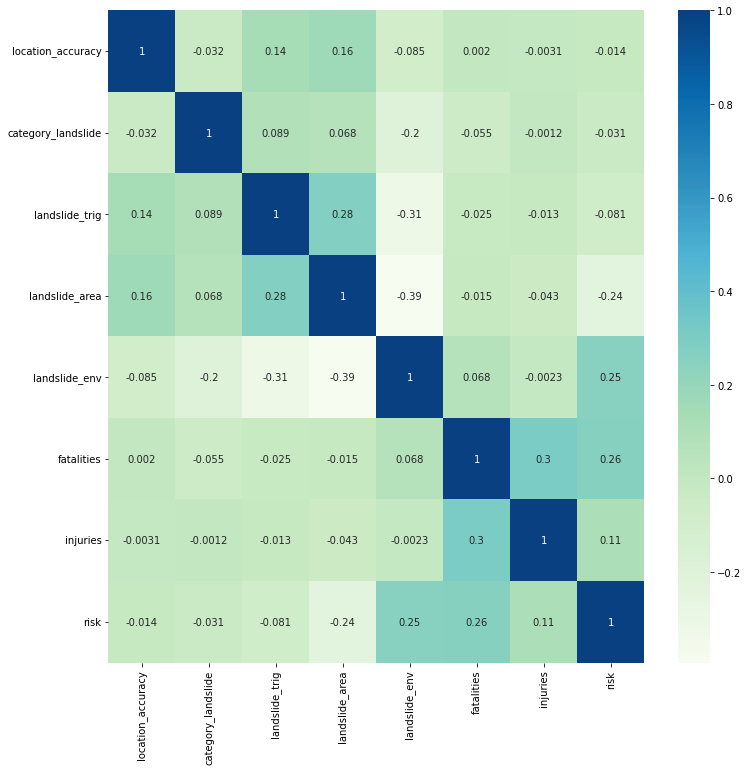

In [21]:
#simple correlation matrix 
plt.figure(figsize=(12,12))
correlation=scaled_slide.corr()
sns.heatmap(correlation,cmap = "GnBu", annot = True)

In [37]:
#create target:y and features:x
x=scaled_slide.iloc[:,:5]
y=scaled_slide.iloc[:,-1]

In [58]:
#simple model and fit based on label encoding
model=RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x,y)
print(model.feature_importances_)

[0.18210473 0.11721618 0.21376428 0.20116883 0.28574597]


<function matplotlib.pyplot.show(close=None, block=None)>

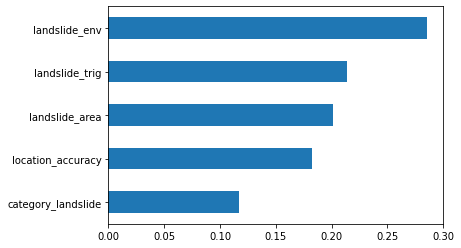

In [59]:
#display label encoding version of the model results
feat_importance=pd.Series(model.feature_importances_,index=x.columns).sort_values()
feat_importance.plot(kind="barh")
plt.show
#All selected features hold prominence, suprisingly location accuracy serves more prominent than category of landslide

In [60]:
#convert categorical values into a relation of true/false values
o_h_e = pd.get_dummies(norm_fatalities[["category_landslide", "landslide_trig", "landslide_area", "landslide_env", "location_accuracy"]])

In [61]:
o_h_e.shape

(10914, 61)

In [62]:
#convert categorical values into numeric values based on target encoding
te = TargetEncoder(smooth="auto",target_type='binary')
X_trans = te.fit_transform(x, y)
features_encoded = pd.DataFrame(X_trans, columns = features.columns)

In [63]:
features_encoded

,category_landslide,landslide_trig,landslide_area,landslide_env,location_accuracy
0,0.032142,0.178794,0.194678,0.527169,0.332264
1,0.032142,0.178794,0.194678,0.279913,0.332264
2,0.255227,0.188465,0.248506,0.279287,0.342602
3,0.310298,0.248384,0.114478,0.032028,0.298808
4,0.316067,0.247397,0.214084,0.279913,0.332264
...,...,...,...,...,...
10909,0.251462,0.170827,0.102937,0.278377,0.057706
10910,0.310208,0.170827,0.102937,0.278377,0.057706
10911,0.153657,0.252846,0.383852,0.279287,0.297041
10912,0.150869,0.247397,0.109344,0.527169,0.059468


<Axes: >

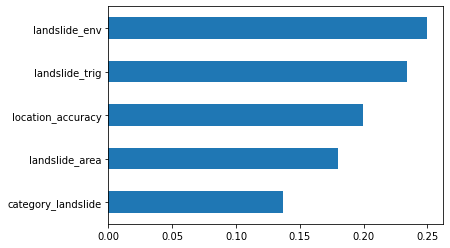

In [65]:
#run,fit, and dispaly model based on target encoding
model_te = RandomForestClassifier(n_estimators=100, random_state=42)
model_te.fit(features_encoded, y)
feature_importances_te = pd.Series(model_te.feature_importances_,index=x.columns).sort_values()
feature_importances_te.plot(kind="barh")

In [68]:
#create hyper paramaters
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
hyper_model=RandomForestClassifier(random_state=42)

In [97]:
#run a cross validation model with 10 folds, scoring based on f1
grid_search = GridSearchCV(estimator=hyper_model, param_grid=param_grid,cv=10, n_jobs=-1, scoring="f1")
grid_search.fit(x, y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [98]:
best_rf_model = grid_search.best_estimator_

In [99]:
#use the highest performing model for feature importance
feature_importances = best_rf_model.feature_importances_

<BarContainer object of 5 artists>

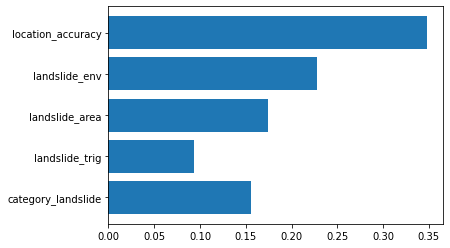

In [100]:
plt.barh(features_encoded.columns, feature_importances)